In [1]:
# from pytorch_segmentation.tree_segmentation import segment_trees

# df = segment_trees("/home/jovyan/work/satellite_data/tmp/inference/unet_18_07_2022_150108_new.pth/2018_10.tif","test_watershed_unet18.sqlite",
#                    footprint=(3,3),min_distance=10,min_size=100,n_cpus=20,cachesize=10,driver="SQLite",patch_size=[1024,1024])

In [2]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.functional import F
from torch import nn
from torch.nn import DataParallel
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random
import torchvision.models as models

from pytorch_segmentation.data.test_dataset import TestSatDataset
from pytorch_segmentation.models import UNet
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [3]:
model_name = "unet_25_01_2023_113846"#"unet_25_08_2022_081902"#"unet_29_07_2022_120212" #"unet_18_07_2022_150108"#"unet_19_07_2022_115722" #"unet_18_07_2022_150108"#"unet_05_05_2022_113034" #"unet_11_07_2022_070457"#"unet_13_07_2022_171256" 
data_parallel = False

classif = False
clf_model = "resnet10131_10_2022_112246"

save_dir = "saved_models"

data_path = "/home/jovyan/work/notebooks/satellite_data/data/test_dataset/V2"
# data_file_path ="/home/jovyan/work/satellite_data/tmp/"
# shape_path="/home/jovyan/work/notebooks/satellite_data/utils/shapes"
# mask_path="/home/jovyan/work/notebooks/satellite_data/data/test_dataset"

test_patch_size = [256,256]
overlap_test = 128

batch_size = 50
nworkers = 10
pin_memory = True

padding = False#True

save_images = False
save_dir_output = "/home/jovyan/work/notebooks/satellite_data/data/out/save_images"
filter_true_empty = False


res_factor = 1

years = [2014,2015,2016,2017,2018,2019]#list(range(2014,2021))
#res_factor = {2008:2,2009:2,2010:2,2011:2,2012:2,2013:2,2014:2,2015:2,2016:2,2017:1,2018:1}


#resampling = {2008:8,2009:8,2010:6,2011:6,2012:6,2013:6,2014:4,2015:4,2016:4,2017:2,2018:2}
#resampling = {2008:8,2009:8,2010:6,2011:6,2012:6,2013:6,2014:6,2015:6,2016:6,2017:2,2018:2}
#resampling = 1
#resampling = {2008:4,2009:1,2010:1,2011:1,2012:1,2013:1,2014:1,2015:1,2016:1,2017:1,2018:1}

In [4]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
if str(device) == "cpu":
    pin_memory = False

test_transform = None

test_transform = seg_transforms.Compose([
    #seg_transforms.UnmaskEdges([225,225]),
     #seg_transforms.CLAHE_Norm(),
    #seg_transforms.Add_VDVI()
    ])

# 1.1 Data Collection

In [5]:
# dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
#                          resampling={2008:True,2009:True,2010:True,2011:True,2012:True,2013:True,2014:True},resampling_factor=8 )

In [6]:
# dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
#                          resampling_factor=resampling )
dataset = TestSatDataset(data_path =data_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform, resampling_factor=res_factor,years=years )

 67%|██████▋   | 18/27 [00:01<00:00, 11.44it/s]

Skipped shape due to nodata!


 18%|█▊        | 12/66 [00:01<00:06,  7.76it/s]

Skipped shape due to nodata!


  6%|▌         | 9/159 [00:00<00:13, 11.03it/s]

Skipped shape due to nodata!


 23%|██▎       | 37/159 [00:03<00:10, 11.52it/s]

Skipped shape due to nodata!


 68%|██████▊   | 108/159 [00:09<00:03, 14.68it/s]

Skipped shape due to nodata!


 23%|██▎       | 32/139 [00:03<00:09, 10.74it/s]

Skipped shape due to nodata!


 61%|██████    | 85/139 [00:07<00:04, 12.31it/s]

Skipped shape due to nodata!


100%|██████████| 139/139 [00:13<00:00, 10.66it/s]

Skipped shape due to nodata!



100%|██████████| 21/21 [00:02<00:00, 10.15it/s]


Size:  429


In [7]:
test_dl = DataLoader(dataset,batch_size=batch_size,num_workers=nworkers,
                     shuffle=False,pin_memory=pin_memory,drop_last=False)

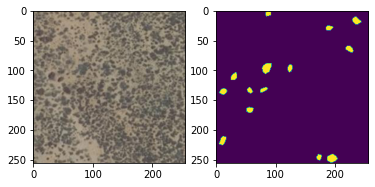

In [8]:
dataset.show_tuple(164)

# 2 Model

In [9]:
model_path = save_dir + "/" + model_name +  ".pth"
state_dict = torch.load(model_path,map_location="cpu")

In [10]:


if data_parallel:
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model_path = save_dir + "/" + model_name +  "_new.pth"
    torch.save(new_state_dict,model_path)
    

## 2.1 Advanced Unet

In [11]:
# Change here to adapt to your data
# n_channels=3 for RGB images 
# n_classes is the number of probabilities you want to get per pixel

net = UNet(n_channels=3, n_classes=2, bilinear=False)
#net= DataParallel(net)

if data_parallel:
    net.load_state_dict(new_state_dict)
else:
    net.load_state_dict(state_dict)
#net.load_state_dict(torch.load(model_path,map_location="cpu"))


#net= DataParallel(net,device_ids=[0,1])
net = net.to(device=device)



# 2.2 ResNet101 Binary

In [12]:
import pytorch_segmentation.augmentation.transforms as seg_transforms

if classif:
    # Change here to adapt to your data
    clf = models.resnet101(pretrained=True)

    fc = nn.Sequential(nn.Linear(2048,1024),nn.ReLU(inplace=True),
                       nn.Linear(1024,512),nn.ReLU(inplace=True),
                       nn.Linear(512,128),nn.ReLU(inplace=True),nn.Linear(128,1))
    #fc = nn.Linear(2048,46)
    clf.fc = fc
    
    clf.load_state_dict(torch.load(os.path.join(save_dir,clf_model+".pth")))

    clf = clf.to(device=device)
    clf.eval()
    
    mean = [0.485, 0.456, 0.406] 
    std = [0.229, 0.224, 0.225]

    transform = seg_transforms.Compose([
        seg_transforms.Normalize(mean, std)
    ])


## 3 Validation

In [15]:
net.eval()
y_pred = torch.empty((len(dataset),256,256)).long()
start_idx = 0

with torch.no_grad(): 
    for i,batch in enumerate(test_dl):
        x = batch["x"]
        
        if classif:
            x_clf = transform(x,None)[0].to(device)
            out = clf(x_clf)
            logits = nn.Sigmoid()(out).squeeze(1)
            non_empty_idx = logits > 0.1
            x = x[non_empty_idx]
            del x_clf
        
        x = x.to(device)
        
        out = net(x)#["out"]
        out = torch.argmax(out,dim=1)
        out = out.cpu()
        
        if classif:
            o = torch.zeros((len(batch["x"]),256,256)).long()
            if len(out) > 0:
                o[non_empty_idx] = out
            out = o
            
        
        end_idx = start_idx + len(out)
        y_pred[start_idx:end_idx] = out
        start_idx += len(out)

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_25_01_2023_113846
##############################
Year 2014: acc     0.986819
iou     0.430706
dice    0.449584
Number of patches: 25
##############################
Year 2015: acc     0.918275
iou     0.451316
dice    0.506418
Number of patches: 26
##############################
Year 2016: acc     0.934912
iou     0.486620
dice    0.563376
Number of patches: 65
##############################
Year 2017: acc     0.986534
iou     0.645685
dice    0.706629
Number of patches: 156
##############################
Year 2018: acc     0.926363
iou     0.393449
dice    0.455702
Number of patches: 136
##############################
Year 2019: acc     0.943829
iou     0.766058
dice    0.808203
Number of patches: 21

##############################
Total score: acc     0.953426
iou     0.523206
dice    0.583235


# Results

In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_01_12_2022_085945
##############################
Year 2014: acc     0.986035
iou     0.461193
dice    0.496503
Number of patches: 25
##############################
Year 2015: acc     0.922195
iou     0.517196
dice    0.594247
Number of patches: 26
##############################
Year 2016: acc     0.936397
iou     0.531913
dice    0.618776
Number of patches: 65
##############################
Year 2017: acc     0.986868
iou     0.655881
dice    0.722339
Number of patches: 156
##############################
Year 2018: acc     0.926652
iou     0.406892
dice    0.470387
Number of patches: 136
##############################
Year 2019: acc     0.946504
iou     0.677118
dice    0.716360
Number of patches: 21

##############################
Total score: acc     0.954188
iou     0.539454
dice    0.605558


In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_15_12_2022_111006
##############################
Year 2014: acc     0.987191
iou     0.436878
dice    0.460739
Number of patches: 25
##############################
Year 2015: acc     0.928354
iou     0.503438
dice    0.564688
Number of patches: 26
##############################
Year 2016: acc     0.936648
iou     0.542543
dice    0.621550
Number of patches: 65
##############################
Year 2017: acc     0.987431
iou     0.660975
dice    0.719535
Number of patches: 156
##############################
Year 2018: acc     0.932991
iou     0.390923
dice    0.455243
Number of patches: 136
##############################
Year 2019: acc     0.935765
iou     0.706037
dice    0.743146
Number of patches: 21

##############################
Total score: acc     0.956355
iou     0.537019
dice    0.597593


In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_01_12_2022_085945
##############################
Year 2014: acc     0.986035
iou     0.461193
dice    0.496503
Number of patches: 25
##############################
Year 2015: acc     0.922195
iou     0.517196
dice    0.594247
Number of patches: 26
##############################
Year 2016: acc     0.936397
iou     0.531913
dice    0.618776
Number of patches: 65
##############################
Year 2018: acc     0.926652
iou     0.406892
dice    0.470387
Number of patches: 136
##############################
Year 2019: acc     0.946504
iou     0.677118
dice    0.716360
Number of patches: 21

##############################
Total score: acc     0.935513
iou     0.472923
dice    0.538827


In [14]:
dataset.evaluate(y_pred,model_name,save_dir=save_dir_output,
                 save_images=save_images,filter_true_empty=filter_true_empty);#,tmpdir="/tmp/test")

Model: unet_15_12_2022_111006
##############################
Year 2014: acc     0.987191
iou     0.436878
dice    0.460739
Number of patches: 25
##############################
Year 2015: acc     0.928354
iou     0.503438
dice    0.564688
Number of patches: 26
##############################
Year 2016: acc     0.936648
iou     0.542543
dice    0.621550
Number of patches: 65
##############################
Year 2018: acc     0.932991
iou     0.390925
dice    0.455245
Number of patches: 136
##############################
Year 2019: acc     0.935765
iou     0.706037
dice    0.743146
Number of patches: 21

##############################
Total score: acc     0.938597
iou     0.466188
dice    0.527914
